In [32]:
import numpy as np 
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit #for data preprocessing and crass validating 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression #logistic Regression
from sklearn.ensemble import RandomForestRegressor #Random Forest 

from statistics import mean
from hyperopt import Trials, hp, fmin, tpe, STATUS_OK, space_eval #for hyperparameter tuning and minimizing

from cyclic_boosting.pipelines import pipeline_CBClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

from datetime import date
from datetime import datetime

import tensorflow as tf

import keras
import keras.layers as layers
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping

import itertools
from keras.layers import LSTM

import seaborn as sns 

In [33]:
samples = pd.read_csv('preprocessed.csv')
samples['date'] = pd.to_datetime(samples['date'])
reading_types = pd.read_csv('reading_types.csv')

samples.info()

df_lst = [(k, v) for k, v in samples.groupby('building_id')]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124278 entries, 0 to 124277
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Unnamed: 0     124278 non-null  int64         
 1   date           124278 non-null  datetime64[ns]
 2   building_id    124278 non-null  int64         
 3   1              124278 non-null  float64       
 4   2              124278 non-null  float64       
 5   3              124278 non-null  float64       
 6   4              124278 non-null  float64       
 7   5              124278 non-null  float64       
 8   6              124278 non-null  float64       
 9   7              124278 non-null  float64       
 10  8              124278 non-null  float64       
 11  9              124278 non-null  float64       
 12  10             124278 non-null  float64       
 13  11             124278 non-null  float64       
 14  12             124278 non-null  float64       
 15  

<class 'pandas.core.frame.DataFrame'>
Index: 7433 entries, 0 to 124275
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   1              7433 non-null   float64
 1   2              7433 non-null   float64
 2   3              7433 non-null   float64
 3   4              7433 non-null   float64
 4   5              7433 non-null   float64
 5   6              7433 non-null   float64
 6   7              7433 non-null   float64
 7   8              7433 non-null   float64
 8   9              7433 non-null   float64
 9   10             7433 non-null   float64
 10  11             7433 non-null   float64
 11  12             7433 non-null   float64
 12  day type       7433 non-null   int64  
 13  Fall           7433 non-null   bool   
 14  Spring         7433 non-null   bool   
 15  Summer         7433 non-null   bool   
 16  Winter         7433 non-null   bool   
 17  trimester_day  7433 non-null   int64  
 18  working_hou

KeyError: "['Date'] not in index"

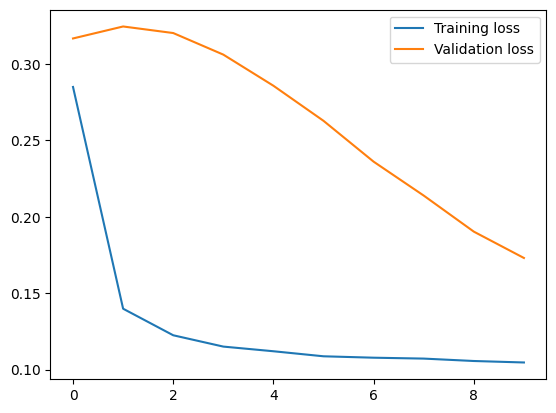

In [37]:
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import StandardScaler


for building, df in df_lst[0:1]:
    train_dates = pd.to_datetime(df['date'])
    multivariate = df.drop(['Unnamed: 0', 'building_id', 'date'], axis = 1)  
    multivariate.info()
    multivariate = multivariate.astype('float32')
    multivariate = multivariate[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']]

    sz = len(multivariate)
    train_sz = int(sz * 0.5)
    test_sz = len(multivariate) - train_sz

    scaler = StandardScaler()  
    scaler = scaler.fit(multivariate) 
    df_scaled = scaler.transform(multivariate)

    train, test = df_scaled[0:train_sz,:], df_scaled[train_sz:sz,:]

    def create_dataset(dataset, look_back = 1):
        dataX, dataY = [], []
        for i in range(len(dataset) - look_back - 1):
            a = dataset[i:(i + look_back), :]
            dataX.append(a)
            dataY.append(dataset[i + look_back, :])
        return np.array(dataX), np.array(dataY)
    
    look_back = 3
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX, trainY = np.array(trainX), np.array(trainY)

    print('trainX shape == {}.'.format(trainX.shape))
    print('trainY shape == {}.'.format(trainY.shape))

    # x_train, x_test, y_train, y_test = train_test_split(df.drop(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], axis = 1), df[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']])
    # x_train = np.asarray(x_train).astype(np.float32)
    # y_train = np.asarray(y_train).astype(np.float32)
    model = keras.Sequential()
    model.add(layers.LSTM(64,input_shape = (trainX.shape[1], trainX.shape[2])))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(12))

    model.compile(optimizer= tf.keras.optimizers.Adam(), loss= tf.keras.losses.Huber())

    history = model.fit(trainX, trainY, batch_size=64, validation_split = 0.2, epochs=10, verbose = 1)
    
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()

    predict_range = 20

    n_future = pd.date_range(list(train_dates)[-look_back], periods= predict_range, freq = 'H').tolist()
    print(n_future)

    prediction = model.predict(trainX[-predict_range:])

    y_pred_future = scaler.inverse_transform(prediction)[:, 10]

    forecast_dates = []
    for time_i in n_future:
        forecast_dates.append(time_i.date())

    df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'Temperature':y_pred_future})
    df_forecast['date']=pd.to_datetime(df_forecast['date'])

    original = df[['date', '11']]
    original['date']=pd.to_datetime(original['date'])
    original = original.loc[original['date'] >= '2020-5-1']

    sns.lineplot(original['date'], original['11'])
    sns.lineplot(df_forecast['date'], df_forecast['11'])
    